# Import all necessary libraries

In [1]:
!pip install pyngrok

In [2]:
# 1. Python standard imports
import os
import threading
import time

# 2. Import third party libraries
import pandas as pd
import numpy as np
from flask import Flask, request, jsonify
from pyngrok import ngrok
from google.colab import userdata

# 3. Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 4. Set pandas option
pd.set_option('display.max_columns', None)

# 5. Import serialization
import pickle

In [40]:
ngrok.set_auth_token(userdata.get('AUTH_TOKEN'))

# Building Machine Learning Model

## Load datasets

In [3]:
mpl_df = pd.read_csv("/content/mpl_id_s14.csv")
attributes_df = pd.read_csv("/content/mlbb_heroes_attribute.csv")

## Check datasets info

In [4]:
mpl_df.head()

,no,week,date,match,game,game_length,blue_team,blue_explaner,blue_jungler,blue_midlaner,blue_goldlaner,blue_roamer,red_team,red_explaner,red_jungler,red_midlaner,red_goldlaner,red_roamer,result
0,1,1,aug-9,1,1,22,TLID,Edith,Julian,Luo Yi,Moskov,Minotaur,FNOC,Arlott,Roger,Valentina,Harith,Chou,RED
1,2,1,aug-9,1,2,17,FNOC,Thamuz,Nolan,Valentina,Harith,Minotaur,TLID,Arlott,Joy,Vexana,Roger,Edith,BLUE
2,3,1,aug-9,2,1,13,DEWA,Hylos,Julian,Valentina,Claude,Edith,EVOS,Ruby,Nolan,Vexana,Moskov,Khufra,BLUE
3,4,1,aug-9,2,2,16,DEWA,X.Borg,Julian,Valentina,Moskov,Arlott,EVOS,Hylos,Roger,Zhask,Claude,Guinevere,RED
4,5,1,aug-9,2,3,23,DEWA,Paquito,Julian,Valentina,Moskov,Hylos,EVOS,X.Borg,Roger,Novaria,Harith,Guinevere,BLUE


In [5]:
attributes_df.head()

,id,hero,main_role,secondary_role,durability,offense,control_effects,difficulty,main_damage_type,early,mid,late
0,1,Miya,Marksman,NaN,1,7,4,1,physical,0,0,1
1,2,Balmond,Fighter,NaN,8,3,2,1,physical,1,1,0
2,3,Saber,Assassin,NaN,2,6,6,1,physical,0,1,0
3,4,Alice,Mage,Tank,5,5,7,7,magic,0,0,1
4,5,Nana,Mage,NaN,5,6,10,1,magic,0,0,1


In [6]:
mpl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   no              212 non-null    int64 
 1   week            212 non-null    int64 
 2   date            212 non-null    object
 3   match           212 non-null    int64 
 4   game            212 non-null    int64 
 5   game_length     212 non-null    int64 
 6   blue_team       212 non-null    object
 7   blue_explaner   212 non-null    object
 8   blue_jungler    212 non-null    object
 9   blue_midlaner   212 non-null    object
 10  blue_goldlaner  212 non-null    object
 11  blue_roamer     212 non-null    object
 12  red_team        212 non-null    object
 13  red_explaner    212 non-null    object
 14  red_jungler     212 non-null    object
 15  red_midlaner    212 non-null    object
 16  red_goldlaner   212 non-null    object
 17  red_roamer      212 non-null    object
 18  result    

In [7]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                126 non-null    int64 
 1   hero              126 non-null    object
 2   main_role         126 non-null    object
 3   secondary_role    34 non-null     object
 4   durability        126 non-null    int64 
 5   offense           126 non-null    int64 
 6   control_effects   126 non-null    int64 
 7   difficulty        126 non-null    int64 
 8   main_damage_type  126 non-null    object
 9   early             126 non-null    int64 
 10  mid               126 non-null    int64 
 11  late              126 non-null    int64 
dtypes: int64(8), object(4)
memory usage: 11.9+ KB


check class from result column

In [8]:
mpl_df['result'].value_counts()

,count
result,
RED,106
BLUE,106


## Pre-prosessing data

drop unused columns

In [9]:
# drop unused columns from mpl_df
mpl_df.drop(columns=['no','week','date','match','game','game_length','blue_team','red_team'], inplace=True)

In [10]:
# remove unused columns from attributes_df
attributes_df.drop(columns=['id','main_role','secondary_role','main_damage_type'], inplace=True)

## Feature engineering

### def functions

In [11]:
# Fungsi untuk menambahkan sum atribut untuk tiap side
def calculate_side_features(mpl_df, attribute_df):
    # Buat dictionary mapping hero untuk lookup cepat
    attribute_dict = attribute_df.set_index('hero')[['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']].to_dict('index')

    # Fungsi internal untuk menghitung sum atribut dari satu sisi (blue atau red)
    def sum_attributes(row, side):
        positions = ['explaner', 'jungler', 'midlaner', 'goldlaner', 'roamer']
        features = ['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']
        side_sums = {f"{side}_{feature}": 0 for feature in features}

        for pos in positions:
            hero = row[f"{side}_{pos}"]
            if hero in attribute_dict:
                for feature in features:
                    side_sums[f"{side}_{feature}"] += attribute_dict[hero][feature]

        return pd.Series(side_sums)

    # Apply fungsi di atas untuk setiap row di mpl_df
    blue_features = mpl_df.apply(lambda row: sum_attributes(row, 'blue'), axis=1)
    red_features = mpl_df.apply(lambda row: sum_attributes(row, 'red'), axis=1)

    # Gabungkan hasil ke mpl_df
    mpl_df = pd.concat([mpl_df, blue_features, red_features], axis=1)

    # Hitung total power spike untuk tiap side
    mpl_df['blue_total_power_spike'] = mpl_df[['blue_early', 'blue_mid', 'blue_late']].sum(axis=1)
    mpl_df['red_total_power_spike'] = mpl_df[['red_early', 'red_mid', 'red_late']].sum(axis=1)

    return mpl_df

In [12]:
# fungsi untuk menghitung Differences in Team Attributes and Performance
def perform_feature_engineering(mpl_df):
    # Feature engineering berdasarkan perbedaan atribut
    mpl_df['durability_diff'] = mpl_df['blue_durability'] - mpl_df['red_durability']
    mpl_df['offense_diff'] = mpl_df['blue_offense'] - mpl_df['red_offense']
    mpl_df['control_effects_diff'] = mpl_df['blue_control_effects'] - mpl_df['red_control_effects']
    mpl_df['difficulty_diff'] = mpl_df['blue_difficulty'] - mpl_df['red_difficulty']
    mpl_df['power_spike_diff'] = mpl_df['blue_total_power_spike'] - mpl_df['red_total_power_spike']

    # Average nilai untuk role per team
    mpl_df['blue_avg_durability'] = mpl_df['blue_durability'] / 5
    mpl_df['red_avg_durability'] = mpl_df['red_durability'] / 5
    mpl_df['blue_avg_offense'] = mpl_df['blue_offense'] / 5
    mpl_df['red_avg_offense'] = mpl_df['red_offense'] / 5

    # Skor aggressiveness
    mpl_df['blue_aggressiveness_score'] = mpl_df['blue_offense'] / mpl_df['blue_durability']
    mpl_df['red_aggressiveness_score'] = mpl_df['red_offense'] / mpl_df['red_durability']

    # Perbandingan early-mid dan mid-late untuk tim blue
    mpl_df['blue_early_mid_ratio'] = np.where(mpl_df['blue_mid'] == 0, 1, mpl_df['blue_early'] / mpl_df['blue_mid'])
    mpl_df['blue_mid_late_ratio'] = np.where(mpl_df['blue_late'] == 0, 1, mpl_df['blue_mid'] / mpl_df['blue_late'])

    # Perbandingan early-mid dan mid-late untuk tim red
    mpl_df['red_early_mid_ratio'] = np.where(mpl_df['red_mid'] == 0, 1, mpl_df['red_early'] / mpl_df['red_mid'])
    mpl_df['red_mid_late_ratio'] = np.where(mpl_df['red_late'] == 0, 1, mpl_df['red_mid'] / mpl_df['red_late'])

    # Drop kolom posisi yang tidak dipakai
    mpl_df.drop(columns=[
        'blue_explaner', 'blue_jungler', 'blue_midlaner', 'blue_goldlaner', 'blue_roamer',
        'red_explaner', 'red_jungler', 'red_midlaner', 'red_goldlaner', 'red_roamer'
    ], inplace=True)

    # Drop kolom yang tidak diperlukan untuk model
    mpl_df = mpl_df.drop(columns=[
        'blue_durability', 'blue_offense', 'blue_control_effects', 'blue_difficulty',
        'red_durability', 'red_offense', 'red_control_effects', 'red_difficulty',
        'blue_total_power_spike',
        'blue_early', 'blue_mid', 'blue_late',
        'red_total_power_spike',
        'red_early', 'red_mid', 'red_late'
    ])

    return mpl_df

### apply

In [13]:
# calculate side features
mpl_df_new = calculate_side_features(mpl_df, attributes_df)

In [14]:
# differences in team attributes and performance
mpl_df_transformed = perform_feature_engineering(mpl_df_new)

# rounded 3
mpl_df_transformed = mpl_df_transformed.round(3)

info dataset after feature enginering

In [15]:
mpl_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   result                     212 non-null    object 
 1   durability_diff            212 non-null    int64  
 2   offense_diff               212 non-null    int64  
 3   control_effects_diff       212 non-null    int64  
 4   difficulty_diff            212 non-null    int64  
 5   power_spike_diff           212 non-null    int64  
 6   blue_avg_durability        212 non-null    float64
 7   red_avg_durability         212 non-null    float64
 8   blue_avg_offense           212 non-null    float64
 9   red_avg_offense            212 non-null    float64
 10  blue_aggressiveness_score  212 non-null    float64
 11  red_aggressiveness_score   212 non-null    float64
 12  blue_early_mid_ratio       212 non-null    float64
 13  blue_mid_late_ratio        212 non-null    float64

## Split data

In [16]:
X = mpl_df_transformed.drop(columns=['result'])  # Semua kolom kecuali 'result'
y = mpl_df_transformed['result']  # Kolom target

# Split dataset 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Cek ukuran dari masing-masing dataset
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 159
Test set size: 53


In [17]:
y_train.value_counts()

,count
result,
RED,80
BLUE,79


## Train data

In [18]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(random_state=6)

# Cross Validation dengan 7 fold untuk Random Forest
rf_scores = cross_val_score(rf_model, X, y, cv=7)
print("Random Forest average accuracy:", rf_scores.mean())

Random Forest average accuracy: 0.5993855606758832


In [19]:
# Melatih model Random Forest
model = RandomForestClassifier(random_state=10)
model.fit(X_train, y_train)

# Melakukan prediksi pada data test
y_pred = model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.6226415094339622
Confusion Matrix:
[[15 12]
 [ 8 18]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.65      0.56      0.60        27
         RED       0.60      0.69      0.64        26

    accuracy                           0.62        53
   macro avg       0.63      0.62      0.62        53
weighted avg       0.63      0.62      0.62        53



## Tunning parameter

### Sequential Tuning

In [20]:
for random in range(1, 22, 1):
  rf_model = RandomForestClassifier(random_state=random)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'random:{random} -  Your accuracy is: {accuracy:.3f}')

random:1 -  Your accuracy is: 0.566
random:2 -  Your accuracy is: 0.566
random:3 -  Your accuracy is: 0.604
random:4 -  Your accuracy is: 0.585
random:5 -  Your accuracy is: 0.566
random:6 -  Your accuracy is: 0.528
random:7 -  Your accuracy is: 0.585
random:8 -  Your accuracy is: 0.547
random:9 -  Your accuracy is: 0.604
random:10 -  Your accuracy is: 0.623
random:11 -  Your accuracy is: 0.585
random:12 -  Your accuracy is: 0.566
random:13 -  Your accuracy is: 0.585
random:14 -  Your accuracy is: 0.604
random:15 -  Your accuracy is: 0.528
random:16 -  Your accuracy is: 0.528
random:17 -  Your accuracy is: 0.547
random:18 -  Your accuracy is: 0.585
random:19 -  Your accuracy is: 0.604
random:20 -  Your accuracy is: 0.623
random:21 -  Your accuracy is: 0.585


In [21]:
for est in range(25, 101, 25):
  rf_model = RandomForestClassifier(n_estimators=est, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'n_estimators:{est} -  Your accuracy is: {accuracy:.3f}')

n_estimators:25 -  Your accuracy is: 0.604
n_estimators:50 -  Your accuracy is: 0.642
n_estimators:75 -  Your accuracy is: 0.604
n_estimators:100 -  Your accuracy is: 0.623


In [22]:
for depth in range(2,20,1):
  rf_model = RandomForestClassifier(max_depth=depth, n_estimators=50, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'max_depth:{depth} -  Your accuracy is: {accuracy:.3f}')

max_depth:2 -  Your accuracy is: 0.623
max_depth:3 -  Your accuracy is: 0.642
max_depth:4 -  Your accuracy is: 0.604
max_depth:5 -  Your accuracy is: 0.585
max_depth:6 -  Your accuracy is: 0.604
max_depth:7 -  Your accuracy is: 0.604
max_depth:8 -  Your accuracy is: 0.528
max_depth:9 -  Your accuracy is: 0.566
max_depth:10 -  Your accuracy is: 0.604
max_depth:11 -  Your accuracy is: 0.623
max_depth:12 -  Your accuracy is: 0.604
max_depth:13 -  Your accuracy is: 0.623
max_depth:14 -  Your accuracy is: 0.623
max_depth:15 -  Your accuracy is: 0.623
max_depth:16 -  Your accuracy is: 0.642
max_depth:17 -  Your accuracy is: 0.642
max_depth:18 -  Your accuracy is: 0.642
max_depth:19 -  Your accuracy is: 0.642


In [23]:
for split in range(2,11,1):
  rf_model = RandomForestClassifier(min_samples_split=split, max_depth=3, n_estimators=50, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'split:{split} -  Your accuracy is: {accuracy:.3f}')

split:2 -  Your accuracy is: 0.642
split:3 -  Your accuracy is: 0.642
split:4 -  Your accuracy is: 0.623
split:5 -  Your accuracy is: 0.623
split:6 -  Your accuracy is: 0.623
split:7 -  Your accuracy is: 0.604
split:8 -  Your accuracy is: 0.604
split:9 -  Your accuracy is: 0.623
split:10 -  Your accuracy is: 0.660


In [24]:
for leaf in range(2,11,1):
  rf_model = RandomForestClassifier(min_samples_leaf=leaf, min_samples_split=2, max_depth=3, n_estimators=50, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'leaf:{leaf} -  Your accuracy is: {accuracy:.3f}')

leaf:2 -  Your accuracy is: 0.642
leaf:3 -  Your accuracy is: 0.604
leaf:4 -  Your accuracy is: 0.623
leaf:5 -  Your accuracy is: 0.642
leaf:6 -  Your accuracy is: 0.604
leaf:7 -  Your accuracy is: 0.604
leaf:8 -  Your accuracy is: 0.642
leaf:9 -  Your accuracy is: 0.623
leaf:10 -  Your accuracy is: 0.660


best parameter from sequencial tuning

In [32]:
rf_model_seq = RandomForestClassifier(min_samples_leaf=10, min_samples_split=2, max_depth=3, n_estimators=50, random_state=10)
rf_model_seq.fit(X_train, y_train)
y_pred = rf_model_seq.predict(X_test)

print("Sequential Tuning")

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Sequential Tuning
Accuracy: 0.660377358490566
Confusion Matrix:
[[16 11]
 [ 7 19]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.70      0.59      0.64        27
         RED       0.63      0.73      0.68        26

    accuracy                           0.66        53
   macro avg       0.66      0.66      0.66        53
weighted avg       0.67      0.66      0.66        53



### Hyperparameter Tuning

In [ ]:
# Tentuin parameter grid
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [4, 6, 8, 10],
    'random_state': [4, 8, 10]
}

# Random Forest Model
rf = RandomForestClassifier()

# Grid Search untuk menemukan kombinasi hyperparameter terbaik
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=7, n_jobs=-1, verbose=2, scoring='accuracy')

# Melatih model dengan data training
grid_search.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.3f}")

Fitting 7 folds for each of 576 candidates, totalling 4032 fits
Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 8}
Best Accuracy: 0.604


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [33]:
# Menggunakan model terbaik untuk prediksi
rf_model_grid = RandomForestClassifier(min_samples_leaf=8, min_samples_split=2, max_depth=3, n_estimators=50, random_state=8)
rf_model_grid.fit(X_train, y_train)
y_pred = rf_model_grid.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("GridSearchCV Tunning")

# Hitung akurasi
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
print('Confusion Matrix:')
print(cm)

# Classification report
print('Classification Report:')
print(report)


GridSearchCV Tunning
Accuracy: 0.68
Confusion Matrix:
[[20  7]
 [10 16]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.67      0.74      0.70        27
         RED       0.70      0.62      0.65        26

    accuracy                           0.68        53
   macro avg       0.68      0.68      0.68        53
weighted avg       0.68      0.68      0.68        53



### Manual Tuning

In [34]:
# Melatih model Random Forest
rf_model_man = RandomForestClassifier(
    random_state=91,
    n_estimators=50,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=8,
)
rf_model_man.fit(X_train, y_train)

# Melakukan prediksi pada data test
y_pred = rf_model_man.predict(X_test)

print("Manual Tuning")

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Manual Tuning
Accuracy: 0.70
Confusion Matrix:
[[18  9]
 [ 7 19]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.72      0.67      0.69        27
         RED       0.68      0.73      0.70        26

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53



## Overfitting/Underfitting

In [35]:
# 3. Evaluate on Training Set
y_train_pred = rf_model_man.predict(X_train)
print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

# 4. Evaluate on Test Set
y_test_pred = rf_model_man.predict(X_test)
print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))

# 5. Analyze Overfitting/Underfitting
# Compare training and test scores
train_score = rf_model_man.score(X_train, y_train)
test_score = rf_model_man.score(X_test, y_test)

print(f"Training Accuracy: {train_score:.2f}")
print(f"Test Accuracy: {test_score:.2f}")

if train_score - test_score > 0.1:  # Gap > 10% as threshold
    print("Model might be overfitting.")
elif train_score < 0.6 and test_score < 0.6:  # Low scores as threshold
    print("Model might be underfitting.")
else:
    print("Model seems to be fitting well.")

Classification Report - Training Set
              precision    recall  f1-score   support

        BLUE       0.75      0.75      0.75        79
         RED       0.75      0.75      0.75        80

    accuracy                           0.75       159
   macro avg       0.75      0.75      0.75       159
weighted avg       0.75      0.75      0.75       159

Classification Report - Test Set
              precision    recall  f1-score   support

        BLUE       0.72      0.67      0.69        27
         RED       0.68      0.73      0.70        26

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53

Training Accuracy: 0.75
Test Accuracy: 0.70
Model seems to be fitting well.


## Confussion Matrix for highest accuration

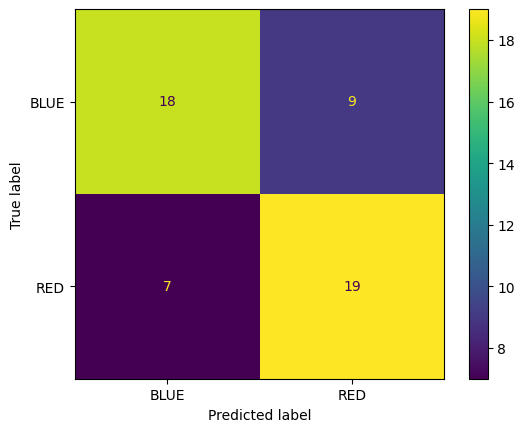

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model_man.classes_)
disp.plot()

## Test Model for new data

In [ ]:
mpl_df_test = pd.DataFrame({
    'blue_explaner': ['Chou'],
    'blue_jungler': ['Alpha'],
    'blue_midlaner': ['Vexana'],
    'blue_goldlaner': ['Irithel'],
    'blue_roamer': ['Mathilda'],
    'red_explaner': ['Edith'],
    'red_jungler': ['Ling'],
    'red_midlaner': ['Yve'],
    'red_goldlaner': ['Natan'],
    'red_roamer': ['Hylos'],
    'result': ['RED']
})

attributes_df_test = pd.DataFrame({
    'hero': [
      'Chou', 'Alpha', 'Vexana', 'Irithel', 'Mathilda',
      'Edith', 'Ling', 'Yve', 'Natan', 'Hylos'
    ],
    'durability': [
        5, 6, 2, 1, 8,
        7, 5, 4, 2, 10
    ],
    'offense': [
        3, 4, 9, 8, 2,
        3, 6, 8, 8, 2
    ],
    'control_effects': [
        8, 7, 5, 1, 4,
        10, 3, 4, 2, 8
    ],
    'difficulty': [
        7, 1, 1, 5, 4,
        3, 7, 7, 2, 3
    ],
    'early': [
        1, 1, 1, 0, 1,
        0, 0, 0, 0, 1
    ],
    'mid': [
        0, 1, 1, 1, 0,
        1, 1, 1, 0, 0
    ],
    'late': [
        0, 0, 0, 0, 0,
        1, 1, 1, 1, 0
    ]
})

In [ ]:
mpl_df_new_test = calculate_side_features(mpl_df_test, attributes_df_test)
mpl_df_transformed_test = perform_feature_engineering(mpl_df_new_test)

In [ ]:
# Use the trained model to predict on new data
new_prediction = rf_model_man.predict(mpl_df_transformed_test.drop(columns=['result']))
print(f"Prediction for the new data: {new_prediction[0]}")
print(f"Actual value of the new data: {mpl_df_transformed_test['result'][0]}")

Prediction for the new data: RED
Actual value of the new data: RED


# Save Pre-trained Model

In [ ]:
# Menyimpan model
with open('model_rf.pkl', 'wb') as file:
    pickle.dump(rf_model_man, file)

# Building Server

## Helper Function

In [ ]:
# feature_engineering
def helper_function(mpl_df, attribute_df):
    # Buat dictionary hero untuk lookup cepat
    attribute_dict = attribute_df.set_index('hero')[['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']].to_dict('index')

    # Fungsi untuk menghitung total atribut untuk setiap tim
    def sum_attributes(row, side):
        positions = ['explaner', 'jungler', 'midlaner', 'goldlaner', 'roamer']
        features = ['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']
        side_sums = {f"{side}_{feature}": sum(attribute_dict.get(row[f"{side}_{pos}"], {}).get(feature, 0) for pos in positions) for feature in features}
        return pd.Series(side_sums)

    # Apply fungsi sum_attributes untuk blue dan red team
    blue_features = mpl_df.apply(lambda row: sum_attributes(row, 'blue'), axis=1)
    red_features = mpl_df.apply(lambda row: sum_attributes(row, 'red'), axis=1)

    # Gabungkan hasil ke dalam mpl_df
    mpl_df = pd.concat([mpl_df, blue_features, red_features], axis=1)

    # Hitung total power spike
    mpl_df['blue_total_power_spike'] = mpl_df[['blue_early', 'blue_mid', 'blue_late']].sum(axis=1)
    mpl_df['red_total_power_spike'] = mpl_df[['red_early', 'red_mid', 'red_late']].sum(axis=1)

    # Tambahkan perbedaan atribut
    mpl_df['durability_diff'] = mpl_df['blue_durability'] - mpl_df['red_durability']
    mpl_df['offense_diff'] = mpl_df['blue_offense'] - mpl_df['red_offense']
    mpl_df['control_effects_diff'] = mpl_df['blue_control_effects'] - mpl_df['red_control_effects']
    mpl_df['difficulty_diff'] = mpl_df['blue_difficulty'] - mpl_df['red_difficulty']
    mpl_df['power_spike_diff'] = mpl_df['blue_total_power_spike'] - mpl_df['red_total_power_spike']

    # Rata-rata nilai untuk role per team
    for feature in ['durability', 'offense']:
        mpl_df[f'blue_avg_{feature}'] = mpl_df[f'blue_{feature}'] / 5
        mpl_df[f'red_avg_{feature}'] = mpl_df[f'red_{feature}'] / 5

    # Aggressiveness score
    mpl_df['blue_aggressiveness_score'] = mpl_df['blue_offense'] / mpl_df['blue_durability']
    mpl_df['red_aggressiveness_score'] = mpl_df['red_offense'] / mpl_df['red_durability']

    # Perbandingan early-mid dan mid-late untuk kedua tim
    for side in ['blue', 'red']:
        mpl_df[f'{side}_early_mid_ratio'] = np.where(mpl_df[f'{side}_mid'] == 0, 1, mpl_df[f'{side}_early'] / mpl_df[f'{side}_mid'])
        mpl_df[f'{side}_mid_late_ratio'] = np.where(mpl_df[f'{side}_late'] == 0, 1, mpl_df[f'{side}_mid'] / mpl_df[f'{side}_late'])

    # Drop kolom posisi yang tidak dipakai
    mpl_df.drop(columns=[f'{side}_{pos}' for side in ['blue', 'red'] for pos in ['explaner', 'jungler', 'midlaner', 'goldlaner', 'roamer']], inplace=True)

    # Drop kolom atribut yang sudah dihitung
    drop_columns = [
        'blue_durability', 'blue_offense', 'blue_control_effects', 'blue_difficulty',
        'red_durability', 'red_offense', 'red_control_effects', 'red_difficulty',
        'blue_total_power_spike', 'red_total_power_spike',
        'blue_early', 'blue_mid', 'blue_late',
        'red_early', 'red_mid', 'red_late'
    ]
    mpl_df.drop(columns=drop_columns, inplace=True)

    return mpl_df.round(3)

## Load Pre-trained Model

In [ ]:
# Memuat model
with open('model_rf.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
y_pred = loaded_model.predict(X_test)

# accuration
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=rf_model.classes_)
print('Confusion Matrix:')
print(cm)
print()

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.70

Confusion Matrix:
[[18  9]
 [ 7 19]]

Classification Report:
              precision    recall  f1-score   support

        BLUE       0.72      0.67      0.69        27
         RED       0.68      0.73      0.70        26

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53



## Init Flask Server

In [38]:
app = Flask(__name__)
port = "5000"

In [ ]:
_shutdown_event = threading.Event()

def shutdown_server():
    _shutdown_event.set()

In [ ]:
@app.route("/")
def index():
    return "Hello from Colab!"


@app.route('/shutdown')
def shutdown():
    shutdown_server()
    return 'Server shutting down...'


@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    picks_df = pd.DataFrame(data['data_picks'])
    attributes_df = pd.DataFrame(data['attributes'])

    # Lakukan feature engineering
    processed_data = helper_function(picks_df, attributes_df)

    # Prediksi kelas
    prediction = loaded_model.predict(processed_data)

    # Konversi hasil prediksi ke string (misalnya 'RED' atau 'BLUE')
    result = {'prediction': str(prediction[0])}

    return jsonify(result)

## Ngrok

In [41]:
# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"")

 * ngrok tunnel "https://ee70-34-85-228-150.ngrok-free.app" -> "http://127.0.0.1:5000"


## Run Server

In [ ]:
# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()

In [ ]:
ngrok.disconnect(public_url)

if necessary

In [ ]:
os._exit(0)